In [6]:
cd G:\Osmanabad LARUS 1.0 25Sep2022_11Oct2022\MODIS L2 Aqua 3km Global

G:\Osmanabad LARUS 1.0 25Sep2022_11Oct2022\MODIS L2 Aqua 3km Global


 # Mosaicing MODIS Level 2 Global AOD and Visualizing 

In [7]:
import os
import glob 
import numpy as np
import pandas as pd
import sys as s
from netCDF4 import Dataset
from pyhdf.SD import SD, SDC
from pyresample import kd_tree,geometry
from pyresample.plot import area_def2basemap
from pyresample import load_area, save_quicklook 
from pyresample.geometry import GridDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest                                                                 
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mticker
import cartopy as cartopy
import cartopy.crs as ccrs
from cartopy import config
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [5]:
data_f = []
days = np.arange(270,272) # Julian dates

for k in days:
    
    i = 0
    for file in list(glob.glob(r'MYD04_3K.A2022'+str(k)+'*.hdf')):
        reader = open(file)
        hdf = SD(file, SDC.READ)
        # Read dataset.
        data2D = hdf.select('Optical_Depth_Land_And_Ocean')
        data = data2D[:,:].astype(np.double)
        # Read geolocation dataset.
        lat = hdf.select('Latitude')
        latitude = lat[:,:]
        lon = hdf.select('Longitude')
        longitude = lon[:,:]
        # Retrieve attributes.
        attrs = data2D.attributes(full=1)
        aoa=attrs["add_offset"]
        add_offset = aoa[0]
        fva=attrs["_FillValue"]
        _FillValue = fva[0]
        sfa=attrs["scale_factor"]
        scale_factor = sfa[0]        
        ua=attrs["units"]
        units = ua[0]
        data[data == _FillValue] = np.nan
        datam = (data - add_offset) * scale_factor 
        if i == 0 :
            data_m = datam
            latitude_m = latitude
            longitude_m = longitude
        else:
            data_m = np.vstack([data_m, datam])
            latitude_m = np.vstack([latitude_m, latitude])
            longitude_m = np.vstack([longitude_m, longitude])
        i = i + 1
        # Regrid.

        # Define SwathDefinition.
        swathDef = SwathDefinition(lons=longitude_m, lats=latitude_m)
    
        # Define GridDefinition.
        # 0.1 degree is about 10.11km, which is close enough to native resolution.
        cellSize = 0.5
        min_lon = -180#np.min(longitude_m)
        max_lon = 180#np.max(longitude_m)
        min_lat = -90#np.min(latitude_m)
        max_lat = 90#np.max(latitude_m)
        x0, xinc, y0, yinc = (min_lon, cellSize, max_lat, -cellSize)
        nx = int(np.floor((max_lon - min_lon) / cellSize))
        ny = int(np.floor((max_lat - min_lat) / cellSize))
        x = np.linspace(x0, x0 + xinc*nx, nx)
        y = np.linspace(y0, y0 + yinc*ny, ny)
        lon_g, lat_g = np.meshgrid(x, y)
        grid_def = GridDefinition(lons=lon_g, lats=lat_g)
        # Set radius_of_influence in meters.
        ri = 10000
        result = resample_nearest(swathDef, data_m, grid_def, 
                              radius_of_influence=ri, epsilon=0.5,
                              fill_value=np.nan)
        [cols, rows] = result.shape
    data_f.append(result)
    result = None

Text(0.5, 1.0, 'MODIS AOD 3KM on 27th Sep 2022')

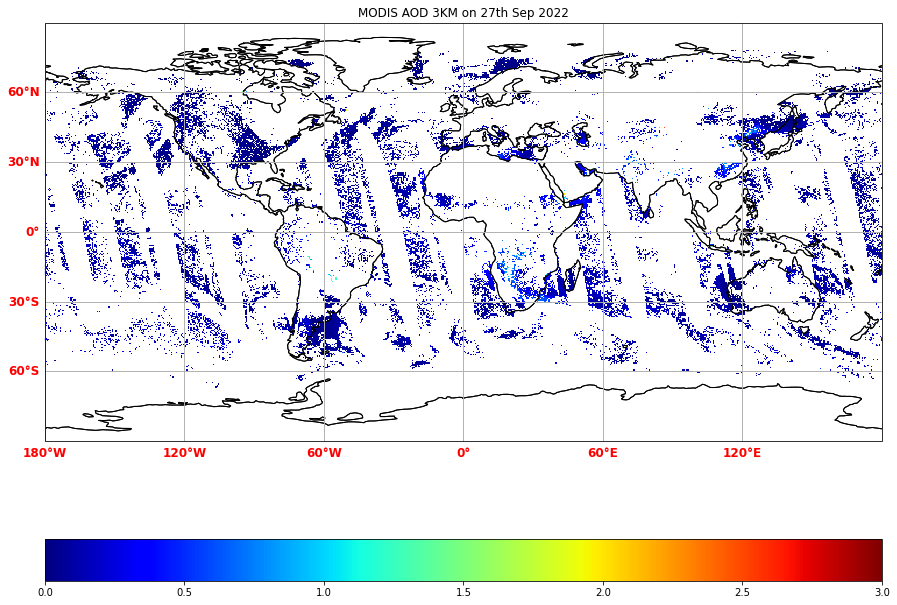

In [14]:
plt.figure(figsize=(15,12),facecolor = 'none')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180,1800,-90,90], crs=ccrs.PlateCarree()) # [lonmin,lonmax,latmin,latmax]
ax.coastlines()
# ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
#                   edgecolor='black', alpha=0.5,lw = 2, facecolor='none') #
#     ax.add_feature(cfeature.LAND, edgecolor='black')
#     ax.add_feature(cfeature.BORDERS)
#     ax.add_feature(cfeature.STATES.with_scale('10m'),
#                linestyle='-', alpha=.25, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines()
filled_c = ax.pcolormesh(x, y, np.array(data_f)[0,:,:], cmap = 'jet',vmin = 0 , vmax = 3)#,transform=ccrs.PlateCarree()), #s=1,
#                       
# filled_c = ax.contourf(latitude_m,longitude_m, c=data_m, transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='jet') 
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12,'color': 'red', 'weight': 'bold'}
gl.ylabel_style = {'size': 12,'color': 'red', 'weight': 'bold'}
        # Add a colorbar for the filled contour.
plt.colorbar(filled_c,ax=ax, orientation='horizontal')
plt.title('MODIS AOD 3KM on 27th Sep 2022')
# plt.savefig('27092022_3km.jpg',dpi=720)
# plt.show()